In [1]:
import os
import sys

#some code to fix a bug reltaed to my vir env
if 'VIRTUAL_ENV' in os.environ:
    py_version = sys.version_info[:2] # formatted as X.Y 
    py_infix = os.path.join('lib', ('python%d.%d' % py_version))
    virtual_site = os.path.join(os.environ.get('VIRTUAL_ENV'), py_infix, 'site-packages')
    dist_site = os.path.join('/usr', py_infix, 'dist-packages')

    # OPTIONAL: exclude debian-based system distributions sites
    # ADD1: sys.path must be a list
    sys.path = list(filter(lambda p: not p.startswith(dist_site), sys.path))

    # add virtualenv site
    # ADD2: insert(0 is wrong and breaks conformance of sys.path
    sys.path.insert(1, virtual_site)

In [2]:
import os,sys,inspect
sys.path.insert(0,os.path.dirname(os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))))

In [3]:
from server.py_rmpe_config import RmpeCocoConfig
from utils.data import DataIterator
from utils.data_torch import CocoPoseDataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import numpy as np

/home/muhammed/deniz/vir-deniz/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Define generator parameters
`batch_size`: number of batches

`num_outs`: number of intermediate losses in the network

`data_dir`: directory to coco dataset, `/slow_data/muhammed/mscoco` for DL servers

In [4]:
batch_size = 1
num_outs   = 1
#data_dir   = '/media/muhammed/Other/RESEARCH/datasets/MSCOCO/coco/'
data_dir = "/slow_data/muhammed/mscoco/"

# Initialize data generator class
It takes some time due to large `.h5` file.

Note that `visualize` parameter should be `False` during training. Figure out why we need a `visualize` parameter?

Set `augment=False` to see the effect of augmentation

In [5]:
"""
train_client = DataIterator(os.path.join(data_dir, 'coco_train_dataset_480.h5'),
                            RmpeCocoConfig,
                            shuffle=True,
                            augment=True,
                            batch_size=batch_size,
                            num_out=num_outs,
                            visualize=True)
"""
train_client = CocoPoseDataset(os.path.join(data_dir, 'coco_train_dataset_480.h5'),
                            RmpeCocoConfig,
                            augment=False,
                            num_out=num_outs,
                            visualize=True)
                                                        

117576


Since `CocoPoseDataset` is a torch dataset, we load it in to a `DataLoader` which is a generator itself. We can iterate it by hand by wrapping it with a `iter()`

Also note that for some reasons `num_worker` does not work for more than one worker.

In [6]:
#train_gen = train_client.gen()
train_gen = iter(DataLoader(train_client,batch_size=1,shuffle=True,num_workers=0))

Sample output from the generator.

You can walk through the dataset by invoking the `next()` function of generator

In [7]:
X, Y = next(train_gen)
print('Input type: %s, size: %d. Output type: %s, size: %d'%(type(X), len(X), type(Y), len(Y)))
for i in range(len(X)):
    print('X[%d] shape: %s'%(i, X[i].shape))
for i in range(len(Y)):
    print('Y[%d] shape: %s'%(i, Y[i].shape))

(18, 120, 120)
(18, 120, 120)
(120, 120)
torch.Size([19, 120, 120])
Input type: <class 'list'>, size: 2. Output type: <class 'list'>, size: 1
X[0] shape: torch.Size([1, 3, 480, 480])
X[1] shape: torch.Size([1, 19, 120, 120])
Y[0] shape: torch.Size([1, 19, 120, 120])


# Visualize the sample results
Parse the outputs

In [8]:
image     = X[0][0]
loss_mask = X[1][0]
heatmaps  = Y[0][0]
print(image.shape)
print(loss_mask.shape)
print(heatmaps.shape)

torch.Size([3, 480, 480])
torch.Size([19, 120, 120])
torch.Size([19, 120, 120])


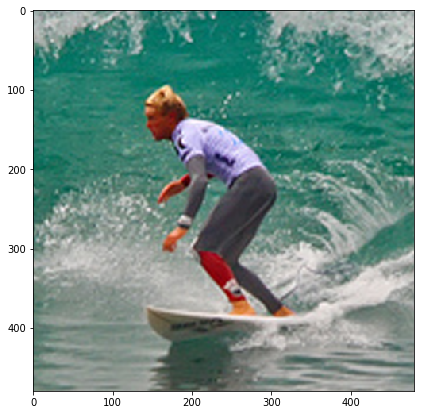

In [9]:
plt.figure(figsize=(7,7))
show_image = np.transpose(image.numpy(),(1,2,0))[:,:,::-1]
plt.imshow(show_image)

Overlay ground-truth heatmaps on the image to debug the correctness.

(19, 120, 120)


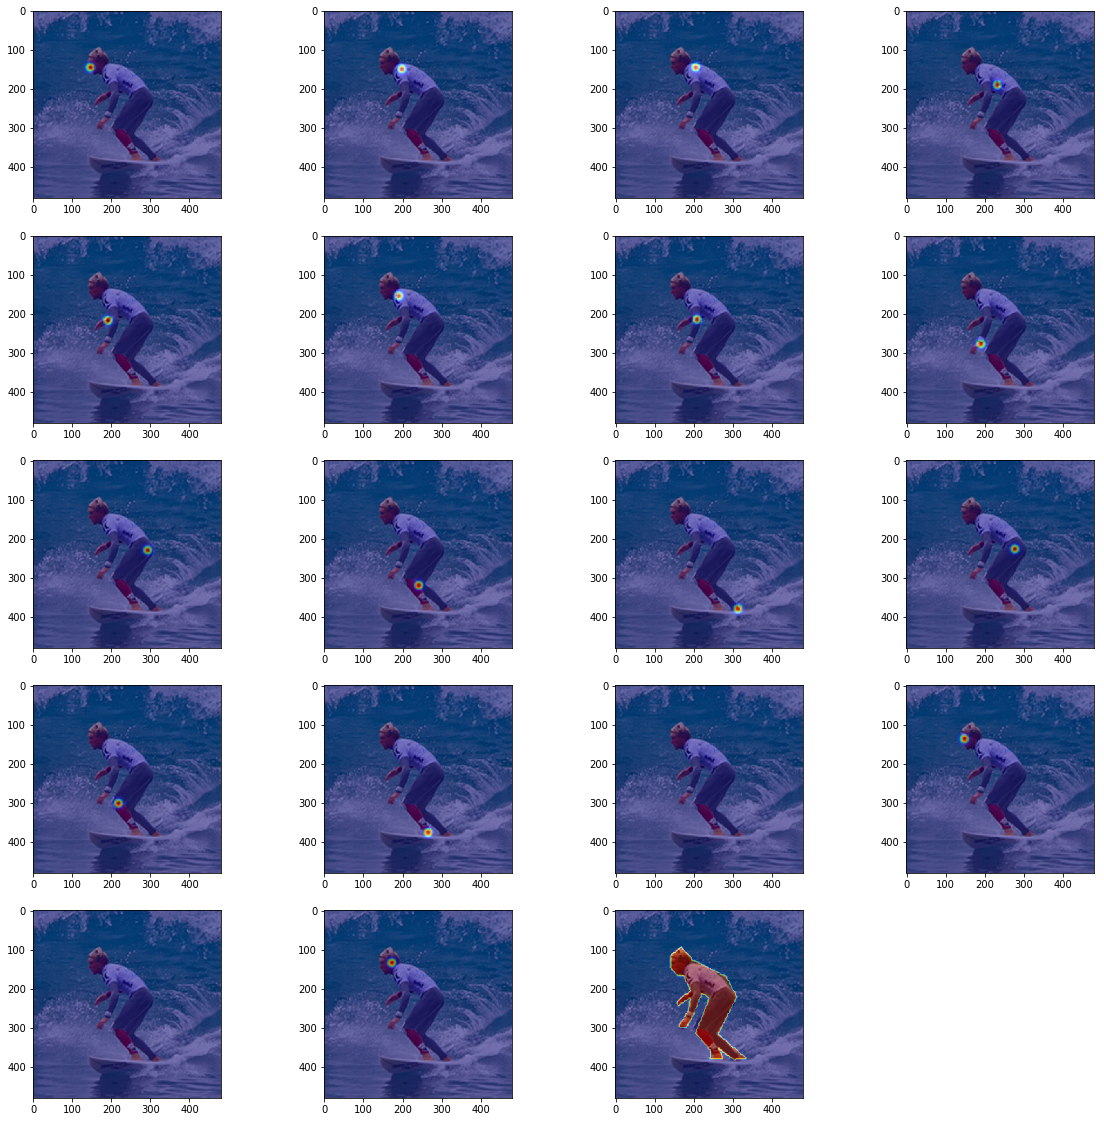

In [10]:


f, axarr = plt.subplots(5, 4)
f.set_size_inches((20, 20))
n_heatmaps = heatmaps.numpy()
print(n_heatmaps.shape)
for ch in range(19):
    axarr[ch//4,ch%4].imshow(show_image)
    heatmap = cv2.resize(n_heatmaps[ch,:,:], (show_image.shape[1], show_image.shape[0]), cv2.INTER_LANCZOS4)
    axarr[ch//4,ch%4].imshow(heatmap, alpha=.5, cmap='jet', interpolation='none')

axarr[4,3].axis('off')
axarr[4,3].imshow(np.ones((384,256,3)))



Now let's see masked images. Note that mask is all ones for most of the images.

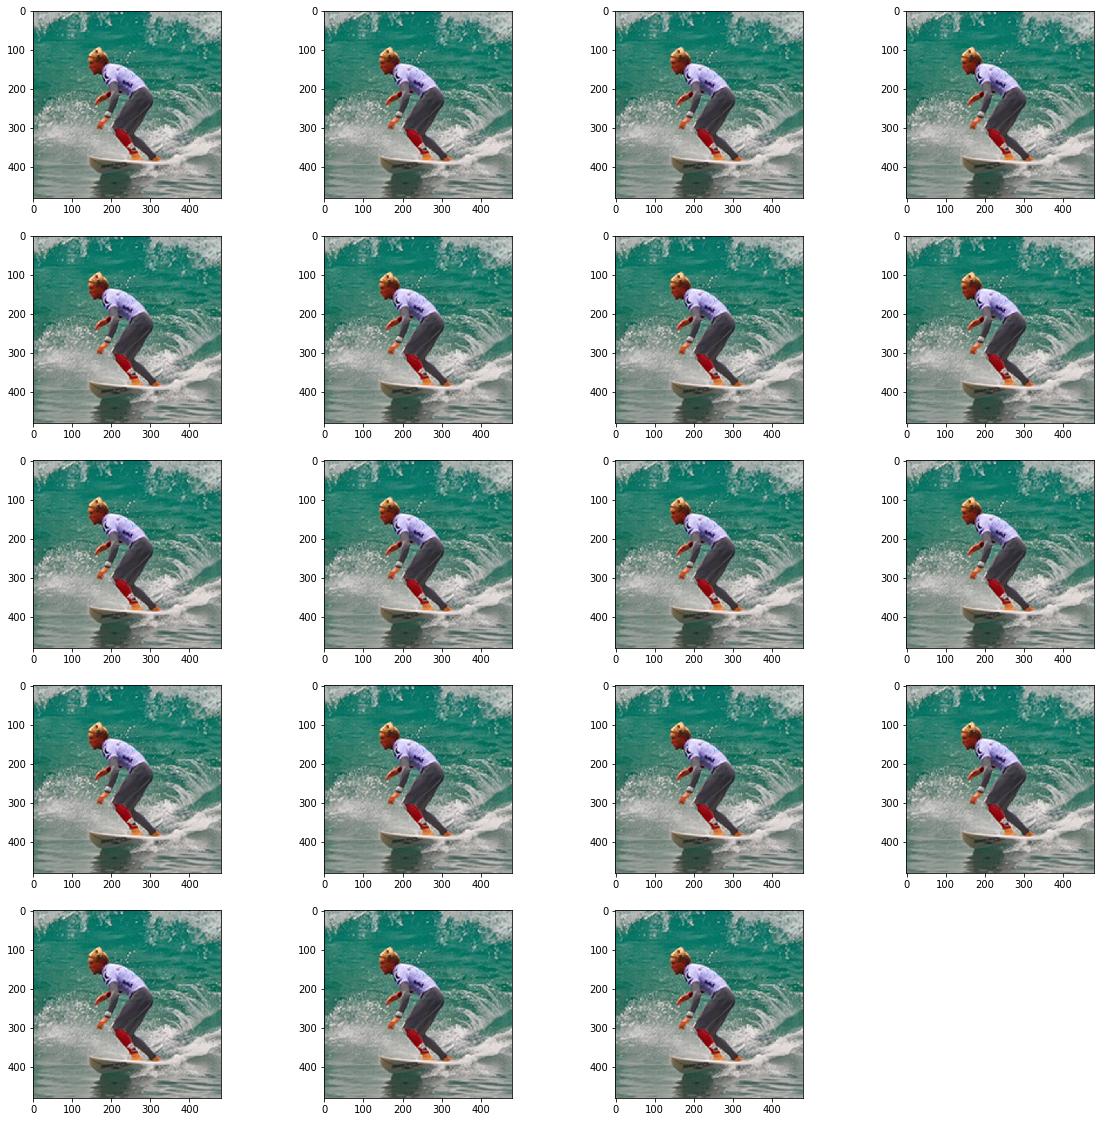

In [11]:
f, axarr = plt.subplots(5, 4)
f.set_size_inches((20, 20))
n_loss_mask = loss_mask.numpy()
for ch in range(19):
    heatmap = cv2.resize(n_loss_mask[ch,:,:], (show_image.shape[1], show_image.shape[0]), cv2.INTER_LANCZOS4)
    heatmap = heatmap[np.newaxis,...]
    heatmap= np.vstack((heatmap,heatmap,heatmap))
    heatmap = np.transpose(heatmap, (1,2,0))
    
    heatmap = (show_image*heatmap).astype(int)
    axarr[ch//4,ch%4].imshow(heatmap)
    #axarr[ch//4,ch%4].imshow(heatmap, alpha=.5, cmap='jet', interpolation='none')

axarr[4,3].axis('off')
axarr[4,3].imshow(np.ones((384,256,3)))

TypeError: Invalid dimensions for image data

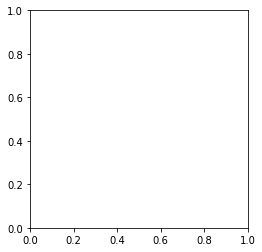

In [12]:
plt.imshow(loss_mask)